In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pygimli as pg # Muy importante tener PyGIMLi instalado
from pygimli.physics import VESManager
from pygimli.physics.ves import VESManager  

import scipy.stats as stats
from scipy.stats import norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from typing import Dict, Any, List, Tuple, Optional

import joblib  # Para guardar y cargar modelos

import seaborn as sns

In [94]:

# Este archivo contiene los siguientes valores:
# modelo, sitio, Espesor_1, Espesor_2, Espesor_3, Resistividad_1-4, AB_1-30.
df = pd.read_csv('DATOS/Modelos-caracterizados-completo.csv')

# Definir las columnas de interés
columnas = ['Espesor_1', 'Espesor_2', 'Espesor_3', 
                      'Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4']

# Agrupar por 'Sitio'
grouped = df.groupby('Sitio')

# Calcular estadísticas: media, desviación estándar, mediana, mínimo, máximo
stats = grouped[columnas].agg(['mean', 'std', 'median', 'min', 'max'])
print(stats)

# Exportar a CSV
df_variantes = pd.DataFrame(stats)
stats_2 = "stats.csv"
df_variantes.to_csv(stats_2, index=False)

# Agrupar por sitio y calcular estadísticas

# Crear diccionario para almacenar la suma de desviaciones estándar por sitio
suma_std_por_sitio = {}

# Iterar sobre todos los sitios
for sitio in stats.index:
    std_values = stats.loc[sitio, [('Espesor_1', 'std'), ('Espesor_2', 'std'), ('Espesor_3', 'std')]]
    suma_std_por_sitio[sitio] = std_values.sum()

# Convertir a DataFrame
df_suma_std = pd.DataFrame.from_dict(suma_std_por_sitio, orient='index', columns=['Suma_std_Espesores'])
df_suma_std.index.name = 'Sitio'
df_suma_std = df_suma_std.sort_index()

# Mostrar resultados
print(df_suma_std)


       Espesor_1                                Espesor_2                    \
            mean        std median   min   max       mean        std median   
Sitio                                                                         
1       6.166667   0.208167   6.10  6.00   6.4  69.723333   8.888230  70.00   
2       2.640000   0.844393   3.00  1.30   3.5  10.800000   7.076369   9.00   
3       3.500000   0.707107   3.50  3.00   4.0  26.500000   0.707107  26.50   
4       2.100000   0.692820   1.70  1.70   2.9  13.733333   7.350057  15.70   
5       1.433333   0.665833   1.60  0.70   2.0  13.100000  10.332957   7.90   
6       3.180000   1.159655   3.18  2.36   4.0  18.250000   3.464823  18.25   
7      17.666667  19.655364  10.00  3.00  40.0  20.000000   6.000000  20.00   
8       5.275000   2.025463   4.80  3.50   8.0  17.000000  13.686977  12.50   

                    ... Resistividad_3                                \
        min    max  ...           mean          std   medi

Apartir del resultados estadisticos se observa en el sitio 2 una std total de 5722.1,  una std de 22.5 en los espesores y una std 8919.9 en los vaslores de resitividad, correspondeido a la std mas alta, miesntras que en el sitio 7 se observa uan std total de 954.8, un std de 87.7 en espesores y de 867.1 en resistividades, por lo cual se seleccinana estos dos ecenarios en los que se tiene diferentes distribuciones en los parametros.

Sitios 1, 2 y 8 presentan resistividades muy altas en las capas más profundas (Resistividad_3 y Resistividad_4), lo cual podría indicar materiales secos o altamente resistivos (posiblemente roca compacta o zonas no saturadas).

Sitio 7 presenta una dispersión muy alta tanto en espesores como en resistividades, lo cual sugiere una zona con una estratigrafía muy compleja o una mezcla de materiales conductivos y resistivos.

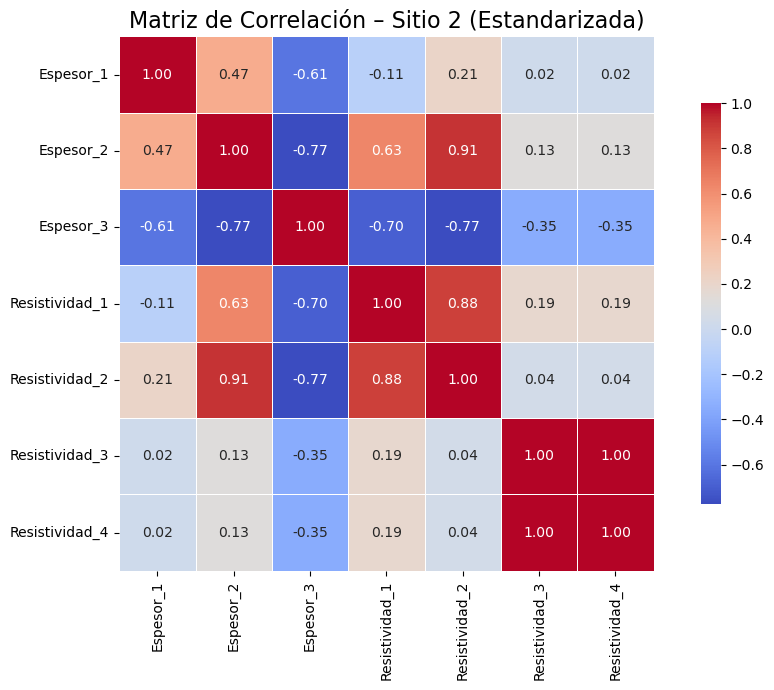

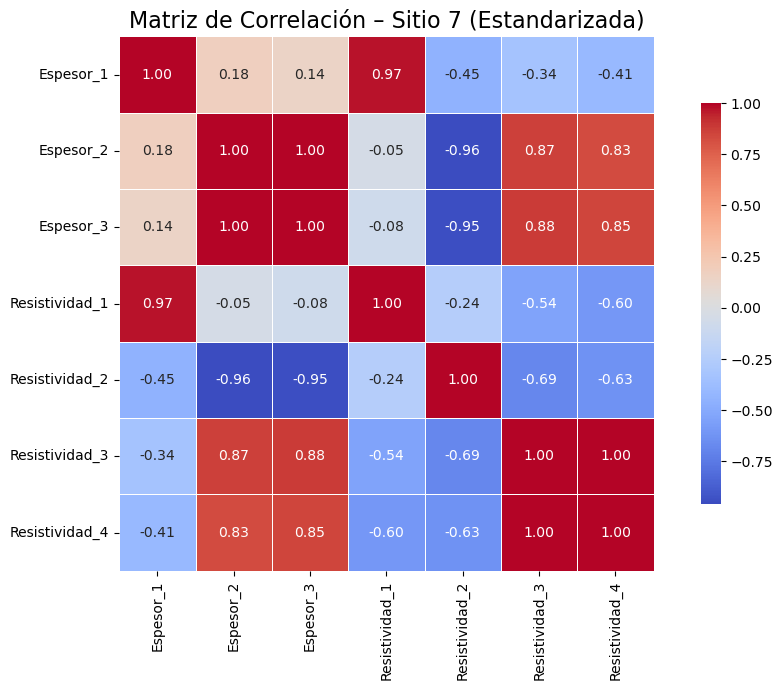

In [95]:
df = pd.read_csv('DATOS/Modelos-caracterizados-completo.csv')

# === 1. Filtrar por sitio 2 ===
sitio_df = df[df['Sitio'] == 2]

# === 2. Definir columnas de interés ===
columnas = [
    'Espesor_1', 'Espesor_2', 'Espesor_3',
    'Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4'
]

# === 3. Iterar sobre los sitios deseados ===
for sitio in [2, 7]:
    # Filtrar datos del sitio
    sitio_df = df[df['Sitio'] == sitio]
    
    # Eliminar filas con datos faltantes
    sitio_data = sitio_df[columnas].dropna()
    
    # Verificar si hay suficientes datos para procesar
    if sitio_data.empty:
        print(f"[!] Sitio {sitio} no tiene datos completos para las columnas seleccionadas.")
        continue

    # Estandarizar los datos
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(sitio_data)

    # Calcular matriz de correlación de Pearson
    correlation_matrix = np.corrcoef(scaled_data, rowvar=False)

    # Convertir a DataFrame con etiquetas
    correlation_df = pd.DataFrame(
        correlation_matrix,
        index=columnas,
        columns=columnas
    )

    # Visualizar la matriz de correlación
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        correlation_df,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title(f"Matriz de Correlación – Sitio {sitio} (Estandarizada)", fontsize=16)
    plt.tight_layout()
    plt.show()


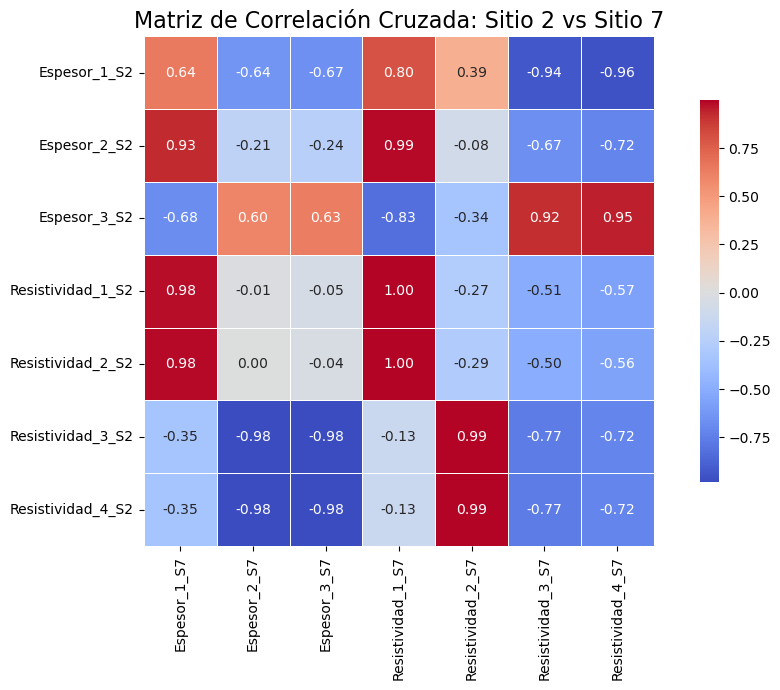

                   Espesor_1_S7  Espesor_2_S7  Espesor_3_S7  \
Espesor_1_S2              0.644        -0.638        -0.666   
Espesor_2_S2              0.926        -0.205        -0.242   
Espesor_3_S2             -0.682         0.599         0.628   
Resistividad_1_S2         0.982        -0.013        -0.051   
Resistividad_2_S2         0.984         0.000        -0.037   
Resistividad_3_S2        -0.346        -0.985        -0.978   
Resistividad_4_S2        -0.346        -0.985        -0.978   

                   Resistividad_1_S7  Resistividad_2_S7  Resistividad_3_S7  \
Espesor_1_S2                   0.799              0.390             -0.938   
Espesor_2_S2                   0.987             -0.084             -0.667   
Espesor_3_S2                  -0.828             -0.344              0.919   
Resistividad_1_S2              0.999             -0.274             -0.512   
Resistividad_2_S2              0.999             -0.287             -0.500   
Resistividad_3_S2          

In [96]:
variables = [
    'Espesor_1', 'Espesor_2', 'Espesor_3',
    'Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4'
]

# === 3. Filtrar sitios y limpiar nulos ===
df2 = df[df['Sitio'] == 2][variables].dropna().reset_index(drop=True)
df7 = df[df['Sitio'] == 7][variables].dropna().reset_index(drop=True)

# === 4. Igualar tamaño de los DataFrames para alineación
min_len = min(len(df2), len(df7))
df2 = df2.iloc[:min_len]
df7 = df7.iloc[:min_len]

# === 5. Renombrar columnas para distinguir sitio
df2.columns = [f"{col}_S2" for col in df2.columns]
df7.columns = [f"{col}_S7" for col in df7.columns]

# === 6. Concatenar ambos dataframes horizontalmente
df_combined = pd.concat([df2, df7], axis=1)

# === 7. Calcular matriz de correlación completa
correlation_matrix = df_combined.corr()

# === 8. Extraer la submatriz cruzada: sitio 2 vs sitio 7
submatrix = correlation_matrix.loc[
    [col for col in correlation_matrix.index if col.endswith('_S2')],
    [col for col in correlation_matrix.columns if col.endswith('_S7')]
]

# === 9. Visualizar la matriz cruzada
plt.figure(figsize=(10, 7))
sns.heatmap(
    submatrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)
plt.title("Matriz de Correlación Cruzada: Sitio 2 vs Sitio 7", fontsize=16)
plt.tight_layout()
plt.show()
# Imprimir la submatriz
print(submatrix.round(3))



No se observa una correlacion directa entre los sitios 2 y 7 por lo tanto la comparacion entre resultados no tendra sesgo.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma


columnas_espesores = ["Espesor_1", "Espesor_2", "Espesor_3"]
distribuciones = [norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma]
sitios_deseados = [2, 7]

resultados_por_espesor = []

# Función para calcular el AIC
def calcular_aic(log_likelihood, k):
    return 2 * k - 2 * log_likelihood

#  filtrado para procesar por sitio (2 y 7) y espesor (1,2 y 3) #
df_filtrado = df[df["Sitio"].isin(sitios_deseados)]


for sitio, datos_sitio in df_filtrado.groupby("Sitio"):
    for espesor in columnas_espesores:
        espesores = datos_sitio[espesor].dropna()

        if len(espesores) < 2:
            continue  # Omitir si hay pocos datos

        resultados = {}
        for dist in distribuciones:
            try:
                params = dist.fit(espesores)
                log_likelihood = np.sum(dist.logpdf(espesores, *params))
                aic = calcular_aic(log_likelihood, len(params))
                ks_stat, p_value = stats.kstest(espesores, dist.cdf, args=params)

                resultados[dist.name] = {
                    'params': params,
                    'KS_stat': ks_stat,
                    'p_value': p_value,
                    'log_likelihood': log_likelihood,
                    'AIC': aic
                }
            except Exception:
                continue  # Ignorar distribuciones que fallen

        if not resultados:
            continue

        # Elegir la mejor distribución según el menor AIC
        mejor_dist = sorted(resultados.items(), key=lambda x: x[1]['AIC'])[0]

        estadisticas = espesores.describe()
        mediana = np.median(espesores)
        moda = stats.mode(espesores, keepdims=False).mode

        resultados_por_espesor.append({
            "Sitio": sitio,
            "Espesor": espesor,
            "Media": estadisticas["mean"],
            "Desviación estándar": estadisticas["std"],
            "Mínimo": estadisticas["min"],
            "Máximo": estadisticas["max"],
            "Mediana": mediana,
            "Moda": moda,
            "Mejor_Distribucion": mejor_dist[0],
            "Parametros": mejor_dist[1]['params'],
            "KS_stat": mejor_dist[1]['KS_stat'],
            "p_value": mejor_dist[1]['p_value'],
            "AIC": mejor_dist[1]['AIC']
        })


resultados_df = pd.DataFrame(resultados_por_espesor)
print(resultados_df.round(5))

# a CSV
df_esta_Hip_27 = pd.DataFrame(resultados_por_espesor)
estadistico_hiperparametros_27 =  "estadistico_hiperparametros_27_2.csv"
df_esta_Hip_27.to_csv(estadistico_hiperparametros_27, index=False)


# se guarda en .pkl
joblib.dump(resultados_por_espesor, "resultados_por_espesor.pkl")



c:\Users\juanj\.conda\envs\pg\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


   Sitio    Espesor      Media  Desviación estándar  Mínimo  Máximo  Mediana  \
0      2  Espesor_1    2.64000              0.84439     1.3     3.5      3.0   
1      2  Espesor_2   10.80000              7.07637     4.5    23.0      9.0   
2      2  Espesor_3   49.50000             14.56880    32.0    66.0     45.5   
3      7  Espesor_1   17.66667             19.65536     3.0    40.0     10.0   
4      7  Espesor_2   20.00000              6.00000    14.0    26.0     20.0   
5      7  Espesor_3  140.66667             62.04300    80.0   204.0    138.0   

   Moda Mejor_Distribucion                                         Parametros  \
0   3.0            lognorm  (14.61366159926754, 1.2999999999999998, 0.0010...   
1   9.0            lognorm  (14.605073800542122, 4.499999999999999, 0.0042...   
2  32.0               beta  (0.40022083185560214, 0.43981305675127835, 31....   
3   3.0            lognorm  (17.986993737838386, 2.9999999999999996, 4.863...   
4  14.0            lognorm  (17.02

['resultados_por_espesor.pkl']

In [ ]:
resultados_cargados = joblib.load("resultados_por_espesor.pkl")

# validando los parametros estadisticos generados
print(resultados_cargados[0])
print(resultados_cargados[1])
print(resultados_cargados[2])
print(resultados_cargados[3])
print(resultados_cargados[4])
print(resultados_cargados[5])

{'Sitio': 2, 'Espesor': 'Espesor_1', 'Media': 2.6399999999999997, 'Desviación estándar': 0.844393273303382, 'Mínimo': 1.3, 'Máximo': 3.5, 'Mediana': 3.0, 'Moda': 3.0, 'Mejor_Distribucion': 'lognorm', 'Parametros': (14.61366159926754, 1.2999999999999998, 0.0010920202374532027), 'KS_stat': 0.48196112363396754, 'p_value': 0.1379092920756172, 'AIC': -21.188305189872928}
{'Sitio': 2, 'Espesor': 'Espesor_2', 'Media': 10.8, 'Desviación estándar': 7.076369125476709, 'Mínimo': 4.5, 'Máximo': 23.0, 'Mediana': 9.0, 'Moda': 9.0, 'Mejor_Distribucion': 'lognorm', 'Parametros': (14.605073800542122, 4.499999999999999, 0.004215328189642214), 'KS_stat': 0.48060079940366923, 'p_value': 0.14002750325547886, 'AIC': -7.687203061153603}
{'Sitio': 2, 'Espesor': 'Espesor_3', 'Media': 49.5, 'Desviación estándar': 14.568802284333465, 'Mínimo': 32.0, 'Máximo': 66.0, 'Mediana': 45.5, 'Moda': 32.0, 'Mejor_Distribucion': 'beta', 'Parametros': (0.40022083185560214, 0.43981305675127835, 31.608409513891722, 34.39159048

In [99]:
###############
##  Sitio 2  ##
###############

S2E1Min = None
S2E1Max = None
S2E1Med = None
for resultado in resultados_cargados:
    if resultado["Sitio"] == 2 and resultado["Espesor"] == "Espesor_1":
        S2E1Min = resultado["Mínimo"]
        S2E1Max = resultado["Máximo"]
        S2E1Med = resultado["Mediana"]
        break  

S2E1MD = None  
S2E1IP = None
S2E1DE = None  
for resultado in resultados_cargados:
    if resultado["Sitio"] == 2 and resultado["Espesor"] == "Espesor_1":
        S2E1MD = resultado["Mejor_Distribucion"]
        S2E1IP = resultado["Parametros"]
        S2E1DE = resultado["Desviación estándar"]
        break 

S2E2Min = None  
S2E2Max = None  
S2E2Med = None   
for resultado in resultados_cargados:
    if resultado["Sitio"] == 2 and resultado["Espesor"] == "Espesor_2":
        S2E2Min = resultado["Mínimo"]
        S2E2Max = resultado["Máximo"]
        S2E2Med = resultado["Mediana"]
        break  

S2E2MD = None  
S2E2IP = None
S2E2DE = None  
for resultado in resultados_cargados:
    if resultado["Sitio"] == 2 and resultado["Espesor"] == "Espesor_2":
        S2E2MD = resultado["Mejor_Distribucion"]
        S2E2IP = resultado["Parametros"]
        S2E2DE = resultado["Desviación estándar"]
        break  
# distribucion Beta
S2E3Min = None 
S2E3Max = None 
S2E3Med = None
for resultado in resultados_cargados:
    if resultado["Sitio"] == 2 and resultado["Espesor"] == "Espesor_3":
        S2E3Min = resultado["Mínimo"]
        S2E3Max = resultado["Máximo"]
        S2E3Med = resultado["Mediana"]
        break

S2E3MD = None
S2E3IP = None
S2E3DE = None
for resultado in resultados_cargados:
    if resultado["Sitio"] == 2 and resultado["Espesor"] == "Espesor_3":
        S2E3MD = resultado["Mejor_Distribucion"]
        S2E3IP = resultado["Parametros"]
        S2E3DE = resultado["Desviación estándar"]
        break

###############
##  Sitio 7  ##
###############


S7E1Min = None
S7E1Max = None
S7E1Med = None
for resultado in resultados_cargados:
    if resultado["Sitio"] == 7 and resultado["Espesor"] == "Espesor_1":
        S7E1Min = resultado["Mínimo"]
        S7E1Max = resultado["Máximo"]
        S7E1Med = resultado["Mediana"]
        break
    
S7E1MD = None  
S7E1IP = None
S7E1DE = None  
for resultado in resultados_cargados:
    if resultado["Sitio"] == 7 and resultado["Espesor"] == "Espesor_1":
        S7E1MD = resultado["Mejor_Distribucion"]
        S7E1IP = resultado["Parametros"]
        S7E1DE = resultado["Desviación estándar"]
        break 

S7E2Min = None
S7E2Max = None
S7E2Med = None
for resultado in resultados_cargados:
    if resultado["Sitio"] == 7 and resultado["Espesor"] == "Espesor_2":
        S7E2Min = resultado["Mínimo"]
        S7E2Max = resultado["Máximo"]
        S7E2Med = resultado["Mediana"]
        break
    
S7E2MD = None  
S7E2IP = None
S7E2DE = None  
for resultado in resultados_cargados:
    if resultado["Sitio"] == 7 and resultado["Espesor"] == "Espesor_2":
        S7E2MD = resultado["Mejor_Distribucion"]
        S7E2IP = resultado["Parametros"]
        S7E2DE = resultado["Desviación estándar"]
        break 

S7E3Min = None
S7E3Max = None
S7E3Med = None
for resultado in resultados_cargados:
    if resultado["Sitio"] == 7 and resultado["Espesor"] == "Espesor_3":
        S7E3Min = resultado["Mínimo"]
        S7E3Max = resultado["Máximo"]
        S7E3Med = resultado["Mediana"]
        break
    
S7E3MD = None  
S7E3IP = None
S7E3DE = None  
for resultado in resultados_cargados:
    if resultado["Sitio"] == 7 and resultado["Espesor"] == "Espesor_3":
        S7E3MD = resultado["Mejor_Distribucion"]
        S7E3IP = resultado["Parametros"]
        S7E3DE = resultado["Desviación estándar"]
        break 


In [100]:
# Definir las columnas de interés
columns = [ 'S2Espesor_3']

# Definir parámetros estadsiticos
params = {
    'S2Espesor_3': {'mean': S2E2Med, 'std': S2E3DE, 'min': S2E2Min, 'max': S2E3Max}
}

##################
n_samples = 10000 #
##################

# Escenario 2: Espesor_2 con distribución beta, pero primero normalizamos los datos

mu = (S2E3Med - S2E3Min)/(S2E3Max - S2E3Min)
var = (S2E3DE * S2E3DE)/((S2E3Max-S2E3Min) * (S2E3Max-S2E3Min))

a = mu * (mu * (1 - mu) / var - 1)
b = (1 - mu) * (mu * (1 - mu) / var - 1)

np.random.seed(42) 
synthetic_data_beta = {}
for col in columns:
    min_val = params[col]['min']
    max_val = params[col]['max']
    
    if col == 'S2Espesor_3':
        data = np.random.beta(a, b, size=n_samples)
        data = min_val + (max_val - min_val) * data
    else:
        mean = params[col]['mean']
        std = params[col]['std']
        data = np.random.normal(mean, std, n_samples)
        data = np.clip(data, min_val, max_val)
    
    synthetic_data_beta[col] = data


synthetic_df_beta = pd.DataFrame(synthetic_data_beta)
print("\nEscenario 2 (espesores con distribucion Beta):")
print(synthetic_df_beta.head())
synthetic_df_beta.to_csv('synthetic_data_beta.csv', index=False)
print("Datos del Escenario 2 guardados en 'synthetic_data_beta.csv'")


Escenario 2 (espesores con distribucion Beta):
   S2Espesor_3
0     4.523648
1    38.536180
2     4.818949
3     4.500000
4     9.932714
Datos del Escenario 2 guardados en 'synthetic_data_beta.csv'


# Definir las columnas de interés
columns = ['S2Espesor_1', 'S2Espesor_2', 'S7Espesor_1', 'S7Espesor_2', 'S7Espesor_3']

# Definir parámetros estadsiticos
params = {
    'S2Espesor_1': {'mean': S2E1Med, 'std': S2E1DE, 'min': S2E1Min, 'max': S2E3Max},
    'S2Espesor_2': {'mean': S2E2Med, 'std': S2E2DE, 'min': S2E2Min, 'max': S2E3Max},
    'S7Espesor_1': {'mean': S7E1Med, 'std': S7E1DE, 'min': S7E1Min, 'max': S7E3Max}, 
    'S7Espesor_2': {'mean': S7E2Med, 'std': S7E2DE, 'min': S7E2Min, 'max': S7E3Max},  
    'S7Espesor_3': {'mean': S7E2Med, 'std': S7E3DE, 'min': S7E2Min, 'max': S7E3Max}
}
##################
n_samples = 10000 #
##################

np.random.seed(42)  
synthetic_data_lognormal = {}
for col in columns:
    min_val = params[col]['min']
    max_val = params[col]['max']
    
    if col == 'S2Espesor_1':
        # Distribución lognormal para Espesor_1
        mu_log = params[col]['mean']#0.8  # Media logarítmica
        sigma_log = params[col]['std']#0.3  # Desviación estándar logarítmica
        data = np.random.lognormal(mean=mu_log, sigma=sigma_log, size=n_samples)
        # Escalar y truncar para respetar límites
        data = np.clip(data, min_val, max_val)
    else:
        # Distribución normal para las demás columnas
        mean = params[col]['mean']
        std = params[col]['std']
        data = np.random.normal(mean, std, n_samples)
        data = np.clip(data, min_val, max_val)
    
    synthetic_data_lognormal[col] = data

# Crear DataFrame para Escenario 1
synthetic_df_lognormal = pd.DataFrame(synthetic_data_lognormal)
print("Escenario 1 (Espesores con distribucion Lognormal):")
print(synthetic_df_lognormal.head())
synthetic_df_lognormal.to_csv('synthetic_data_lognormal.csv', index=False)
print("Datos del Escenario 1 guardados en 'synthetic_data_lognormal.csv'")

In [136]:

columns = ['S2Espesor_1', 'S2Espesor_2', 'S7Espesor_1', 'S7Espesor_2', 'S7Espesor_3']

params = {
    'S2Espesor_1': {'mean': S2E1Med, 'std': S2E1DE, 'min': S2E1Min, 'max': S2E1Max},
    'S2Espesor_2': {'mean': S2E2Med, 'std': S2E2DE, 'min': S2E2Min, 'max': S2E2Max},
    'S7Espesor_1': {'mean': S7E1Med, 'std': S7E1DE, 'min': S7E1Min, 'max': S7E1Max}, 
    'S7Espesor_2': {'mean': S7E2Med, 'std': S7E2DE, 'min': S7E2Min, 'max': S7E2Max},  
    'S7Espesor_3': {'mean': S7E3Med, 'std': S7E3DE, 'min': S7E3Min, 'max': S7E3Max}
}

n_samples = 10000
np.random.seed(42)

synthetic_data_lognormal = {}

for col in columns:
    min_val = params[col]['min']
    max_val = params[col]['max']
    mean_val = params[col]['mean']
    std_val = params[col]['std']

    sigma = np.sqrt(np.log(1 + (std_val / mean_val) ** 2))
    mu = np.log(mean_val) - 0.5 * sigma ** 2

    data = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)
    data = np.clip(data, min_val, max_val)

    synthetic_data_lognormal[col] = data


synthetic_df_lognormal = pd.DataFrame(synthetic_data_lognormal)


print("Escenario 1 – Espesores con distribución Lognormal:")
print(synthetic_df_lognormal.head())

# Exportar a CSV
synthetic_df_lognormal.to_csv('synthetic_data_lognormal.csv', index=False)
print("Datos guardados en 'synthetic_data_lognormal.csv'")


Escenario 1 – Espesores con distribución Lognormal:
   S2Espesor_1  S2Espesor_2  S7Espesor_1  S7Espesor_2  S7Espesor_3
0     3.312301     4.500000     7.026937    14.000000   102.796470
1     2.779622     5.723710     6.475654    14.054483   194.361215
2     3.453298     4.674479     3.000000    16.124102   115.604229
3     3.500000     7.638256     9.399406    20.016967   130.851963
4     2.706993    16.234426     3.000000    25.875509   171.230645
Datos guardados en 'synthetic_data_lognormal.csv'


In [137]:
# escenario 1 resitividades de sitio 2 - S1-AMEBSA 
n_rows = synthetic_df_lognormal.shape[0]
Conjunto_Entrenamiento_S2_1 = {
    "CE": [2] * n_rows,
    "Escenario": [1] * n_rows
}
Conjunto_Entrenamiento_S2_1 = pd.DataFrame(Conjunto_Entrenamiento_S2_1)

n_rows = synthetic_df_lognormal.shape[0]
resistividades_dict_S2_1 = {
    "Resistividad_1": [56.6] * n_rows,
    "Resistividad_2": [350] * n_rows,
    "Resistividad_3": [11000] * n_rows,
    "Resistividad_4": [13200] * n_rows
}
resistividades_df_S2_1 = pd.DataFrame(resistividades_dict_S2_1)

data_test_S2_1 = pd.concat([
    Conjunto_Entrenamiento_S2_1,
    synthetic_df_lognormal[["S2Espesor_1", "S2Espesor_2"]],
    synthetic_df_beta[["S2Espesor_3"]],
    resistividades_df_S2_1
], axis=1)
data_test_S2_1 =data_test_S2_1.rename(columns={'S2Espesor_1': 'Espesor_1',
                                               'S2Espesor_2': 'Espesor_2',
                                                'S2Espesor_3': 'Espesor_3'})

In [138]:
# escenario 2 resitividades de sitio 2 - S2-AMEBSA 
n_rows = synthetic_df_lognormal.shape[0]
Conjunto_Entrenamiento_S2_2 = {
    "CE": [2] * n_rows,
    "Escenario": [2] * n_rows
}
Conjunto_Entrenamiento_S2_2 = pd.DataFrame(Conjunto_Entrenamiento_S2_2)

n_rows = synthetic_df_lognormal.shape[0]
resistividades_dict_S2_2 = {
    "Resistividad_1": [56] * n_rows,
    "Resistividad_2": [350] * n_rows,
    "Resistividad_3": [1500] * n_rows,
    "Resistividad_4": [1800] * n_rows
}
resistividades_df_S2_2 = pd.DataFrame(resistividades_dict_S2_2)

data_test_S2_2 = pd.concat([
    Conjunto_Entrenamiento_S2_2,
    synthetic_df_lognormal[["S2Espesor_1", "S2Espesor_2"]],
    synthetic_df_beta[["S2Espesor_3"]],
    resistividades_df_S2_2
], axis=1)
data_test_S2_2 =data_test_S2_2.rename(columns={'S2Espesor_1': 'Espesor_1',
                                               'S2Espesor_2': 'Espesor_2',
                                                'S2Espesor_3': 'Espesor_3'})

In [139]:
# escenario 3 resitividades de sitio 2 - S3-AMEBSA 
n_rows = synthetic_df_lognormal.shape[0]
Conjunto_Entrenamiento_S2_3 = {
    "CE": [2] * n_rows,
    "Escenario": [3] * n_rows
}
Conjunto_Entrenamiento_S2_3 = pd.DataFrame(Conjunto_Entrenamiento_S2_3)

n_rows = synthetic_df_lognormal.shape[0]
resistividades_dict_S2_3 = {
    "Resistividad_1": [95] * n_rows,
    "Resistividad_2": [1500] * n_rows,
    "Resistividad_3": [4800] * n_rows,
    "Resistividad_4": [57600] * n_rows
}
resistividades_df_S2_3 = pd.DataFrame(resistividades_dict_S2_3)

data_test_S2_3 = pd.concat([
    Conjunto_Entrenamiento_S2_3,
    synthetic_df_lognormal[["S2Espesor_1", "S2Espesor_2"]],
    synthetic_df_beta[["S2Espesor_3"]],
    resistividades_df_S2_3
], axis=1)
data_test_S2_3 =data_test_S2_3.rename(columns={'S2Espesor_1': 'Espesor_1',
                                               'S2Espesor_2': 'Espesor_2',
                                                'S2Espesor_3': 'Espesor_3'})

In [140]:
# escenario 4 resitividades de sitio 2 - S4-AMEBSA 
n_rows = synthetic_df_lognormal.shape[0]
Conjunto_Entrenamiento_S2_4 = {
    "CE": [2] * n_rows,
    "Escenario": [4] * n_rows
}
Conjunto_Entrenamiento_S2_4 = pd.DataFrame(Conjunto_Entrenamiento_S2_4)

n_rows = synthetic_df_lognormal.shape[0]
resistividades_dict_S2_4 = {
    "Resistividad_1": [4] * n_rows,
    "Resistividad_2": [45] * n_rows,
    "Resistividad_3": [3400] * n_rows,
    "Resistividad_4": [4800] * n_rows
}
resistividades_df_S2_4 = pd.DataFrame(resistividades_dict_S2_4)

data_test_S2_4 = pd.concat([
    Conjunto_Entrenamiento_S2_3,
    synthetic_df_lognormal[["S2Espesor_1", "S2Espesor_2"]],
    synthetic_df_beta[["S2Espesor_3"]],
    resistividades_df_S2_4
], axis=1)
data_test_S2_4 =data_test_S2_4.rename(columns={'S2Espesor_1': 'Espesor_1',
                                               'S2Espesor_2': 'Espesor_2',
                                                'S2Espesor_3': 'Espesor_3'})

In [141]:
# escenario 5 resitividades de sitio 2 - S5-AMEBSA 
n_rows = synthetic_df_lognormal.shape[0]
Conjunto_Entrenamiento_S2_5 = {
    "CE": [2] * n_rows,
    "Escenario": [5] * n_rows
}
Conjunto_Entrenamiento_S2_5 = pd.DataFrame(Conjunto_Entrenamiento_S2_5)

n_rows = synthetic_df_lognormal.shape[0]
resistividades_dict_S2_5 = {
    "Resistividad_1": [48] * n_rows,
    "Resistividad_2": [460] * n_rows,
    "Resistividad_3": [2300] * n_rows,
    "Resistividad_4": [2760] * n_rows
}
resistividades_df_S2_5 = pd.DataFrame(resistividades_dict_S2_5)

data_test_S2_5 = pd.concat([
    Conjunto_Entrenamiento_S2_3,
    synthetic_df_lognormal[["S2Espesor_1", "S2Espesor_2"]],
    synthetic_df_beta[["S2Espesor_3"]],
    resistividades_df_S2_5
], axis=1)
data_test_S2_5 =data_test_S2_5.rename(columns={'S2Espesor_1': 'Espesor_1',
                                               'S2Espesor_2': 'Espesor_2',
                                                'S2Espesor_3': 'Espesor_3'})

In [142]:
# escenario 1 resitividades de sitio 7 - S1-EGH-OLV
n_rows = synthetic_df_lognormal.shape[0]
Conjunto_Entrenamiento_S7_1 = {
    "CE": [7] * n_rows,
    "Escenario": [1] * n_rows
}
Conjunto_Entrenamiento_S7_1 = pd.DataFrame(Conjunto_Entrenamiento_S7_1)

n_rows = synthetic_df_lognormal.shape[0]
resistividades_dict_S7_1 = {
    "Resistividad_1": [56] * n_rows,
    "Resistividad_2": [264] * n_rows,
    "Resistividad_3": [85] * n_rows,
    "Resistividad_4": [129] * n_rows
}
resistividades_df_S7_1 = pd.DataFrame(resistividades_dict_S7_1)

data_test_S7_1 = pd.concat([
    Conjunto_Entrenamiento_S7_1,
    synthetic_df_lognormal[["S7Espesor_1", "S7Espesor_2", "S7Espesor_3"]],
    resistividades_df_S7_1
], axis=1)
data_test_S7_1 =data_test_S7_1.rename(columns={'S7Espesor_1': 'Espesor_1',
                                               'S7Espesor_2': 'Espesor_2',
                                                'S7Espesor_3': 'Espesor_3'})

In [143]:
# escenario 2 resitividades de sitio 7 - S2-EGH-OLV
n_rows = synthetic_df_lognormal.shape[0]
Conjunto_Entrenamiento_S7_2 = {
    "CE": [7] * n_rows,
    "Escenario": [2] * n_rows
}
Conjunto_Entrenamiento_S7_2 = pd.DataFrame(Conjunto_Entrenamiento_S7_2)

n_rows = synthetic_df_lognormal.shape[0]
resistividades_dict_S7_2 = {
    "Resistividad_1": [17] * n_rows,
    "Resistividad_2": [48] * n_rows,
    "Resistividad_3": [360] * n_rows,
    "Resistividad_4": [432] * n_rows
}
resistividades_df_S7_2 = pd.DataFrame(resistividades_dict_S7_2)

data_test_S7_2 = pd.concat([
    Conjunto_Entrenamiento_S7_2,
    synthetic_df_lognormal[["S7Espesor_1", "S7Espesor_2", "S7Espesor_3"]],
    resistividades_df_S7_2
], axis=1)
data_test_S7_2 =data_test_S7_2.rename(columns={'S7Espesor_1': 'Espesor_1',
                                               'S7Espesor_2': 'Espesor_2',
                                               'S7Espesor_3': 'Espesor_3'})

In [144]:
# escenario 3 resitividades de sitio 7 - S3-EGH-OLV
n_rows = synthetic_df_lognormal.shape[0]
Conjunto_Entrenamiento_S7_3 = {
    "CE": [7] * n_rows,
    "Escenario": [3] * n_rows
}
Conjunto_Entrenamiento_S7_3 = pd.DataFrame(Conjunto_Entrenamiento_S7_3)

n_rows = synthetic_df_lognormal.shape[0]
resistividades_dict_S7_3 = {
    "Resistividad_1": [750] * n_rows,
    "Resistividad_2": [100] * n_rows,
    "Resistividad_3": [85] * n_rows,
    "Resistividad_4": [102] * n_rows
}
resistividades_df_S7_3 = pd.DataFrame(resistividades_dict_S7_3)

data_test_S7_3 = pd.concat([
    Conjunto_Entrenamiento_S7_3,
    synthetic_df_lognormal[["S7Espesor_1", "S7Espesor_2", "S7Espesor_3"]],
    resistividades_df_S7_3
], axis=1)
data_test_S7_3 =data_test_S7_3.rename(columns={'S7Espesor_1': 'Espesor_1',
                                               'S7Espesor_2': 'Espesor_2',
                                               'S7Espesor_3': 'Espesor_3'})

In [145]:
dt_S2 = pd.concat([data_test_S2_1, data_test_S2_2, data_test_S2_3, data_test_S2_4, data_test_S2_5], ignore_index=True)
dt_S7 = pd.concat([data_test_S7_1, data_test_S7_2, data_test_S7_3], ignore_index=True)

In [146]:
print(dt_S2.head())
print(dt_S2.shape)

   CE  Escenario  Espesor_1  Espesor_2  Espesor_3  Resistividad_1  \
0   2          1   3.312301   4.500000   4.523648            56.6   
1   2          1   2.779622   5.723710  38.536180            56.6   
2   2          1   3.453298   4.674479   4.818949            56.6   
3   2          1   3.500000   7.638256   4.500000            56.6   
4   2          1   2.706993  16.234426   9.932714            56.6   

   Resistividad_2  Resistividad_3  Resistividad_4  
0             350           11000           13200  
1             350           11000           13200  
2             350           11000           13200  
3             350           11000           13200  
4             350           11000           13200  
(50000, 9)


In [147]:
print(dt_S7.head())
print(dt_S7.shape)

   CE  Escenario  Espesor_1  Espesor_2   Espesor_3  Resistividad_1  \
0   7          1   7.026937  14.000000  102.796470              56   
1   7          1   6.475654  14.054483  194.361215              56   
2   7          1   3.000000  16.124102  115.604229              56   
3   7          1   9.399406  20.016967  130.851963              56   
4   7          1   3.000000  25.875509  171.230645              56   

   Resistividad_2  Resistividad_3  Resistividad_4  
0             264              85             129  
1             264              85             129  
2             264              85             129  
3             264              85             129  
4             264              85             129  
(30000, 9)


In [148]:
#######################################################
## vamos a corroborar los datos sinteticos generados ##
#######################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma


Espesores_Sinteticos = ["Espesor_1", "Espesor_2", "Espesor_3"]
distribuciones = [norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma]
Escenario_deseado = [3]

resultados_por_espesor = []

# Función para calcular el AIC
def calcular_aic(log_likelihood, k):
    return 2 * k - 2 * log_likelihood

#  filtrado para procesar por sitio (2 y 7) y espesor (1,2 y 3) # dt_S2
df_filtrado = dt_S2[dt_S2["Escenario"].isin(Escenario_deseado)]


for sitio, datos_sitio in df_filtrado.groupby("Escenario"):
    for espesor in Espesores_Sinteticos:
        espesores = datos_sitio[espesor].dropna()

        if len(espesores) < 2:
            continue  # Omitir si hay pocos datos

        resultados = {}
        for dist in distribuciones:
            try:
                params = dist.fit(espesores)
                log_likelihood = np.sum(dist.logpdf(espesores, *params))
                aic = calcular_aic(log_likelihood, len(params))
                ks_stat, p_value = stats.kstest(espesores, dist.cdf, args=params)

                resultados[dist.name] = {
                    'params': params,
                    'KS_stat': ks_stat,
                    'p_value': p_value,
                    'log_likelihood': log_likelihood,
                    'AIC': aic
                }
            except Exception:
                continue  # Ignorar distribuciones que fallen

        if not resultados:
            continue

        # Elegir la mejor distribución según el menor AIC
        mejor_dist = sorted(resultados.items(), key=lambda x: x[1]['AIC'])[0]

        estadisticas = espesores.describe()
        mediana = np.median(espesores)
        moda = stats.mode(espesores, keepdims=False).mode

        resultados_por_espesor.append({
            "Escenario": sitio,
            "Espesor": espesor,
            "Media": estadisticas["mean"],
            "Desviación estándar": estadisticas["std"],
            "Mínimo": estadisticas["min"],
            "Máximo": estadisticas["max"],
            "Mediana": mediana,
            "Moda": moda,
            "Mejor_Distribucion": mejor_dist[0],
            "Parametros": mejor_dist[1]['params'],
            "KS_stat": mejor_dist[1]['KS_stat'],
            "p_value": mejor_dist[1]['p_value'],
            "AIC": mejor_dist[1]['AIC']
        })


resultados_df = pd.DataFrame(resultados_por_espesor)
print(resultados_df.round(5))

c:\Users\juanj\.conda\envs\pg\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\juanj\.conda\envs\pg\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\juanj\.conda\envs\pg\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


   Escenario    Espesor     Media  Desviación estándar  Mínimo  Máximo  \
0          3  Espesor_1   2.83776              0.57363     1.3     3.5   
1          3  Espesor_2   9.02548              5.27172     4.5    23.0   
2          3  Espesor_3  28.95746             26.33914     4.5    66.0   

    Mediana  Moda Mejor_Distribucion  \
0   2.88572   3.5               beta   
1   7.15319   4.5            lognorm   
2  13.81065   4.5        weibull_min   

                                          Parametros  KS_stat  p_value  \
0  (1.6334704956749189, 0.8868473296592937, 1.189...  0.24036      0.0   
1  (15.67918837784584, 4.499999999999999, 0.00039...  0.38016      0.0   
2  (0.33488630941020014, 4.499999999999999, 17.04...  0.21504      0.0   

            AIC  
0  -18810.34329  
1 -220195.27424  
2  130628.04592  


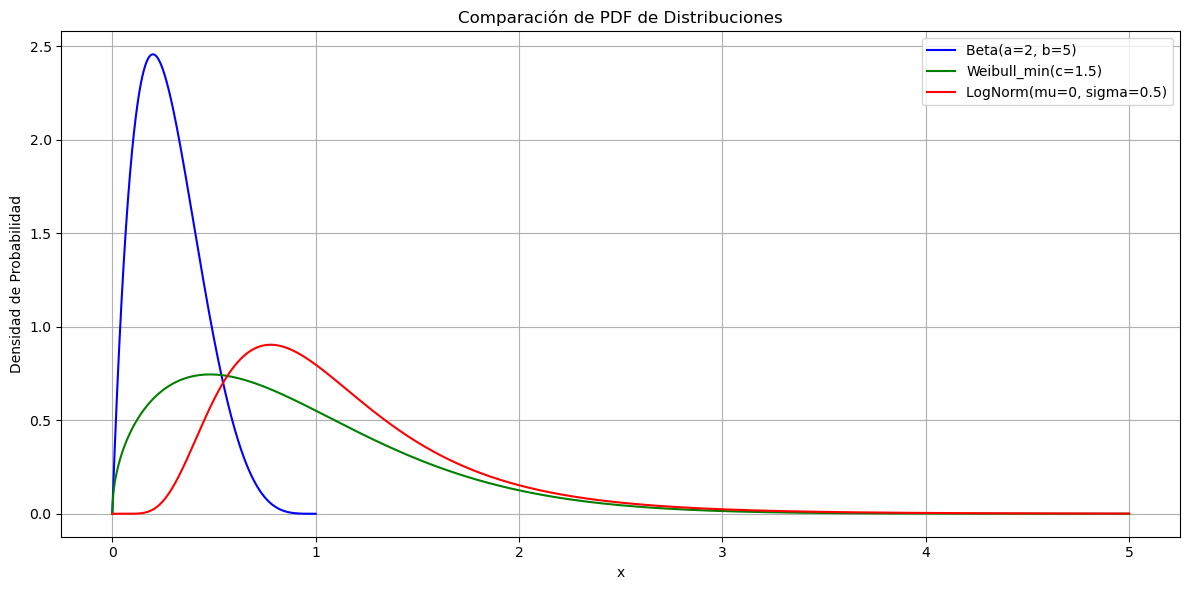

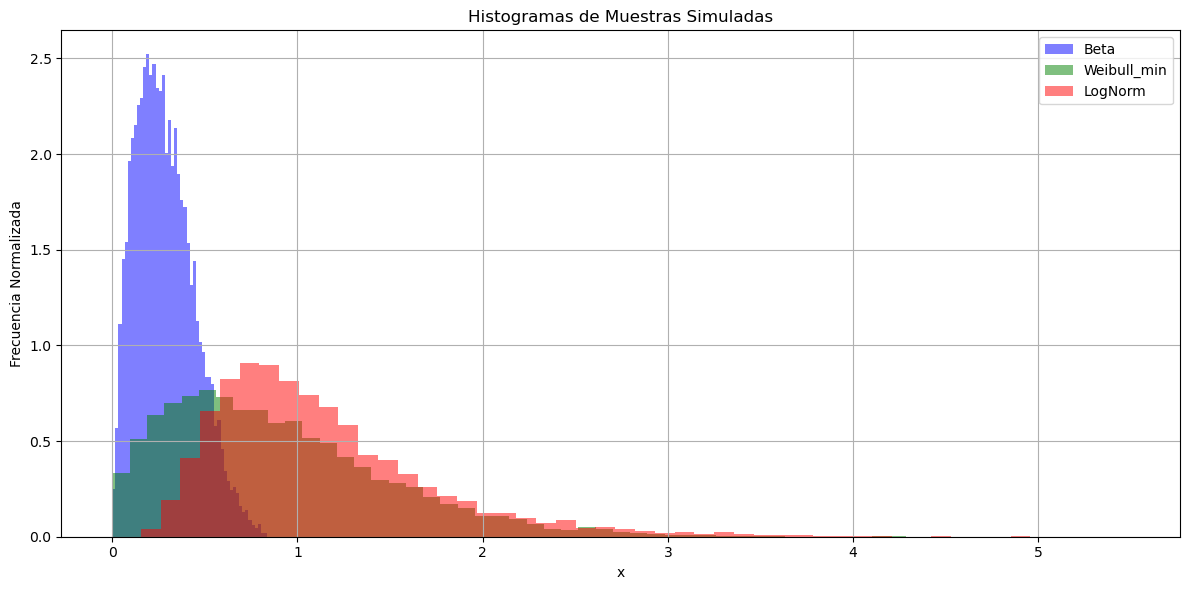

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, weibull_min, lognorm

# --- Simulación de datos ---
np.random.seed(42)
n = 10000

# Parámetros para cada distribución
# Beta(a=2, b=5) en el intervalo [0, 1]
beta_data = beta.rvs(a=2, b=5, size=n)

# Weibull_min(c=1.5) (forma)
weibull_data = weibull_min.rvs(c=1.5, scale=1.0, size=n)

# Lognormal (mu=0.0, sigma=0.5)
lognorm_data = lognorm.rvs(s=0.5, scale=np.exp(0.0), size=n)

# --- Graficar PDF de cada distribución ---
x_beta = np.linspace(0, 1, 1000)
x_weibull = np.linspace(0, 5, 1000)
x_lognorm = np.linspace(0, 5, 1000)

plt.figure(figsize=(12, 6))

# PDF de la distribución beta
plt.plot(x_beta, beta.pdf(x_beta, a=2, b=5), label='Beta(a=2, b=5)', color='blue')

# PDF de la distribución weibull
plt.plot(x_weibull, weibull_min.pdf(x_weibull, c=1.5, scale=1.0), label='Weibull_min(c=1.5)', color='green')

# PDF de la distribución lognormal
plt.plot(x_lognorm, lognorm.pdf(x_lognorm, s=0.5, scale=np.exp(0.0)), label='LogNorm(mu=0, sigma=0.5)', color='red')

plt.title("Comparación de PDF de Distribuciones")
plt.xlabel("x")
plt.ylabel("Densidad de Probabilidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Graficar histogramas comparativos de los datos simulados ---
plt.figure(figsize=(12, 6))
plt.hist(beta_data, bins=50, alpha=0.5, label="Beta", density=True, color='blue')
plt.hist(weibull_data, bins=50, alpha=0.5, label="Weibull_min", density=True, color='green')
plt.hist(lognorm_data, bins=50, alpha=0.5, label="LogNorm", density=True, color='red')

plt.title("Histogramas de Muestras Simuladas")
plt.xlabel("x")
plt.ylabel("Frecuencia Normalizada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
